# Prepare Compass inputs, random groups within cell states

https://yoseflab.github.io/Compass/

Try to capture biological and technical variation by partitioning within replicates divided by age bin, cell/nuclei, cell state

## Setup

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import sctk
import anndata as ad

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'Reds', figsize = (5, 5),dpi_save=300)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
# Perform pseudobulk on sc data

import scipy.sparse as sp

def pseudo_bulk(
        adata, groupby, use_rep='X', highly_variable=False, FUN=np.mean):
    """Make pseudo bulk data from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    if highly_variable:
        if isinstance(highly_variable, (list, tuple)):
            if use_rep == 'raw':
                k_hv = adata.raw.var_names.isin(highly_variable)
            else:
                k_hv = adata.var_names.isin(highly_variable)
        else:
            k_hv = adata.var['highly_variable'].values
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep == 'raw':
        x = adata.raw.X
        features = adata.raw.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        if sp.issparse(x):
            summarised[i] = FUN(x[k_grp, :], axis=0)
        else:
            summarised[i] = FUN(x[k_grp, :], axis=0, keepdims=True)
    return pd.DataFrame(summarised.T, columns=groups, index=features)

def random_partition(
    adata,
    partition_size,
    groupby=None,
    method="random_even",
    key_added="partition_labels",
    random_state=0,
):
    np.random.seed(random_state)
    if groupby:
        if groupby not in adata.obs.columns:
            raise KeyError(f"{groupby} is not a valid obs annotation.")
        groups = adata.obs[groupby].unique()
        label_df = adata.obs[[groupby]].astype(str).rename(columns={groupby: key_added})
        for grp in groups:
            k = adata.obs[groupby] == grp
            grp_size = sum(k)
            n_partition = max(np.round(grp_size / partition_size).astype(int), 1)
            if method == "random":
                part_idx = np.random.randint(low=0, high=n_partition, size=grp_size)
            elif method == "random_even":
                part_sizes = list(map(len, np.array_split(np.arange(grp_size), n_partition)))
                part_idx = np.repeat(np.arange(n_partition), part_sizes)
                np.random.shuffle(part_idx)
            else:
                raise NotImplementedError(method)
            label_df.loc[k, key_added] = [f"{grp},{i}" for i in part_idx]
        adata.obs[key_added] = label_df[key_added]
    else:
        n_partition = max(np.round(adata.n_obs / partition_size).astype(int), 1)
        if method == "random":
            part_idx = np.random.randint(low=0, high=n_partition, size=adata.n_obs)
        elif method == "random_even":
            part_sizes = list(map(len, np.array_split(np.arange(adata.n_obs), n_partition)))
            part_idx = np.repeat(np.arange(n_partition), part_sizes)
            np.random.shuffle(part_idx)
        else:
            raise NotImplementedError(method)
        adata.obs[key_added] = part_idx.astype(str)

## Import suspension data

### Adult

In [10]:
adata = sc.read('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 629041 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [11]:
# set gene name as var_names 
adata.var['gene_id']=adata.var_names.copy()
adata.var.set_index('gene_name_multiome-2',inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()
adata.var

,gene_name_scRNA-0,gene_name_snRNA-1,gene_id
gene_name_multiome-2,,,
MIR1302-2HG,MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,OR4F5,ENSG00000186092
AL627309.1,AL627309.1,AL627309.1,ENSG00000238009
AL627309.3,AL627309.3,AL627309.3,ENSG00000239945
...,...,...,...
AC233755.2,AC233755.2,AC233755.2,ENSG00000277856
AC233755.1,AC233755.1,AC233755.1,ENSG00000275063
AC240274.1,AC240274.1,AC240274.1,ENSG00000271254


In [12]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A'], dtype='object', name='gene_name_multiome-2')
[1. 1. 1. 1. 2.]


In [13]:
sc.pp.log1p(adata)

In [14]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A'], dtype='object', name='gene_name_multiome-2')
[0.6931472 0.6931472 0.6931472 0.6931472 1.0986123]


In [15]:
#subset by CMs only
print(adata.shape)
adata=adata[adata.obs['cell_type'].isin(['Ventricular Cardiomyocyte','Atrial Cardiomyocyte'])]
print(adata.shape)

(629041, 32732)
(226971, 32732)


In [16]:
adult=adata.copy()

### Fetal

In [25]:
adata = sc.read('/nfs/team205/heart/anndata_objects/Foetal/final_annotation/FetalHearts13Aug_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 176050 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region_finest', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key', '_scvi_batch', '_scvi_labels', 'annotation_Semih', 'leiden_scVI', 'cell_type_pre', 'pth', 'ito', 'FACSgate', 'leiden_scVI_0.05', 'leiden_scVI_0.01', 'leiden_scVI_0.1', 'leiden_scVI_0.15', 'leiden_scVI_0.2', 'leiden_scVI_0.25', 'leiden_scVI_0.3', 'leiden_scVI_0.35', 'leiden_scVI_0.4', 'cell_type', 'coarse_grain', 'fine_grain', 'region', 'sex', 'age', 'cycling', 'S_score', 'G2M_sco

In [26]:
# set gene name as var_names 
adata.var['gene_id']=adata.var_names.copy()
adata.var.set_index('gene_name_multiome-1',inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()
adata.var

,gene_name_scRNA-0,gene_id
gene_name_multiome-1,,
MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
AL627309.1,AL627309.1,ENSG00000238009
AL627309.3,AL627309.3,ENSG00000239945
...,...,...
AC141272.1,AC141272.1,ENSG00000277836
AC023491.2,AC023491.2,ENSG00000278633
AC007325.1,AC007325.1,ENSG00000276017


In [27]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A'], dtype='object', name='gene_name_multiome-1')
[1. 1. 5. 5. 8.]


In [28]:
#subset by CMs only
print(adata.shape)
adata=adata[adata.obs['coarse_grain']=='Cardiomyocytes']
print(adata.shape)

(176050, 36601)
(64751, 36601)


In [29]:
sc.pp.log1p(adata)

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A'], dtype='object', name='gene_name_multiome-1')
[1.9459102 0.6931472 1.3862944 0.6931472 0.6931472]


In [31]:
fetal=adata.copy()

### make a combined object by concatenation

In [32]:
# make a label denoting agea

# adult
adult.obs['age_binned']='adult'

# fetal
age_to_agebins = {
    '15W1D':'T2',
    '10W4D':'lateT1',
    '7W4D':'earlyT1',
    '9W4D':'lateT1',
    '9W1D':'lateT1',
    '8W1D':'earlyT1',
    '9W6D':'lateT1',
    '8W2D':'earlyT1',
    '11W3D':'lateT1',
    '12W5D':'lateT1',
    '9W3D':'lateT1',
    '8W5D':'earlyT1',
    '11W2D':'lateT1',
}
fetal.obs['age_binned'] = (
    fetal.obs['age']
    .map(age_to_agebins)
    .astype('category')
)

In [33]:
# make a common label for fine_grain
adult.obs['fine_grain']=adult.obs['cell_state']

In [34]:
#perform concatenation
combined = ad.concat([adult, fetal], join="inner", index_unique=None)
combined

AnnData object with n_obs × n_vars = 291722 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'age_binned', 'fine_grain'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'

In [35]:
print(adult.shape)
print(fetal.shape)
print(combined.shape)

(226971, 32732)
(64751, 36601)
(291722, 32732)


<AxesSubplot:>

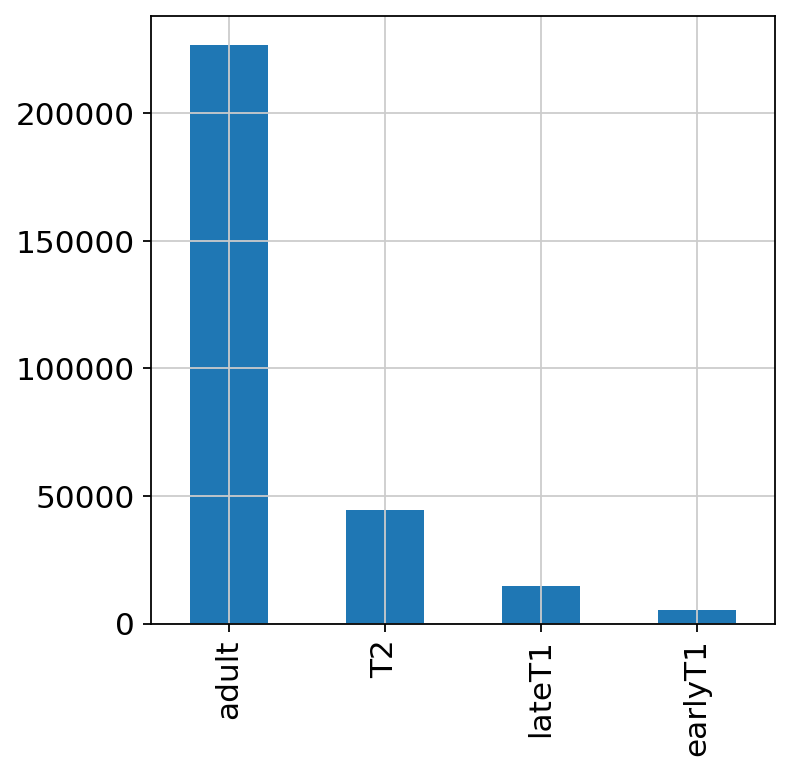

In [36]:
combined.obs['age_binned'].value_counts().plot.bar()

In [37]:
adata=combined

# Prepare data for Compass
"The input gene expression matrix can be either a tab-delimited text file (tsv) or a matrix market format (mtx) containing gene expression estimates (CPM, TPM, or similar scaled units) with one row per gene, one column per sample."

## .mtx method (gene x sampleID, 3 files)
This allows you to specify the 'samples', so rather than calculating reactions in all single cells individually (or micro-pooled) we can make our own "samples" (pseudobulking them)

Need to ensure the samples are representative of the sample. Here we use a new batch key of cell state and the previous batch key  to form the 'samples'
This requires 3 files, to inputted thus ```--data expression.mtx genes.tsv sample_names.tsv```

Another option would be to use Milo or Metacell to make small samples, below I am going to just use the batch key to make samples within each cell state.

In [38]:
# make a label combining cell state, age, and cell vs nuclei
adata.obs['compass_label']=adata.obs['fine_grain'].astype(str)+'_'+adata.obs['age_binned'].astype(str)+'_'+adata.obs['cell_or_nuclei'].astype(str)

In [39]:
adata.obs['compass_label'].value_counts()

vCM1_adult_Nuclei                             97536
vCM2_adult_Nuclei                             34573
vCM4_adult_Nuclei                             27285
vCM3_adult_Nuclei                             25417
aCM1_adult_Nuclei                             17624
                                              ...  
AtrialCardiomyocytesCycling_lateT1_Nuclei        27
AtrialCardiomyocytesCycling_T2_Nuclei            16
AtrialCardiomyocytesCycling_earlyT1_Nuclei        7
aCM1_adult_Cell                                   2
vCM1_adult_Cell                                   2
Name: compass_label, Length: 79, dtype: int64

<AxesSubplot:>

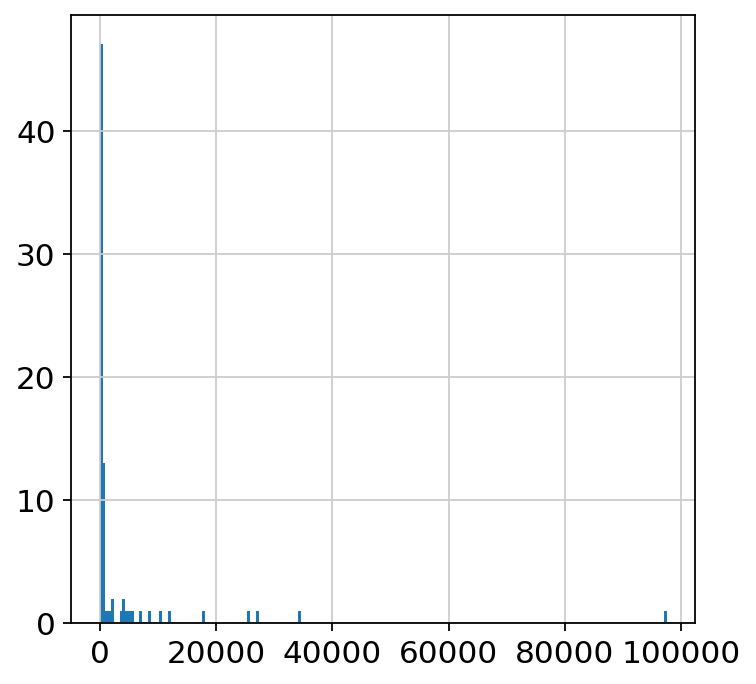

In [40]:
adata.obs['compass_label'].value_counts().hist(bins = 200)

In [41]:
# Make random partition using sctk
random_partition(adata, partition_size=20, groupby="compass_label", key_added="partition_20")

In [42]:
#find out how many groups were made during partitioning
len(adata.obs['partition_20'].unique())

14591

<AxesSubplot:>

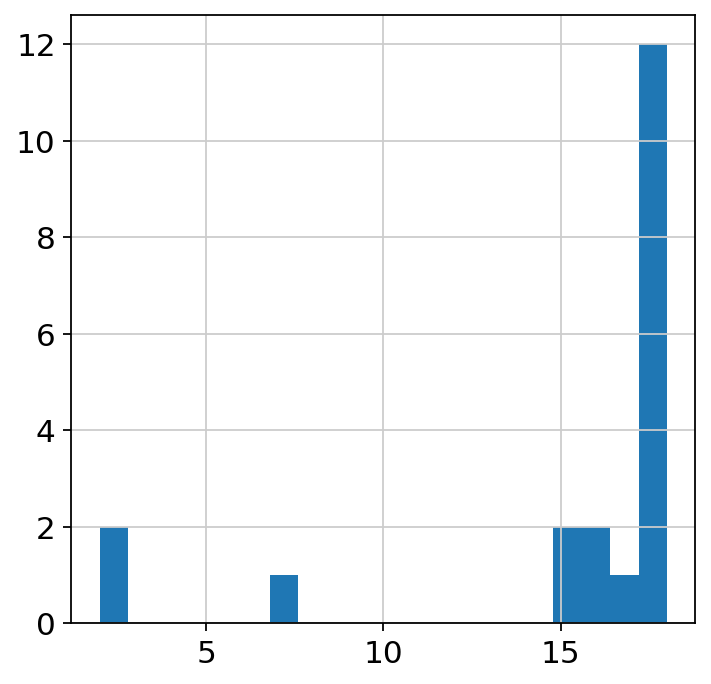

In [43]:
tmp=adata.obs['partition_20'].value_counts()
tmp[tmp<19].hist(bins = 20)

In [44]:
# Pseudobulk use Ni's psudobulk function
pseudo_bulk = pseudo_bulk(adata,
                         groupby='partition_20')

In [45]:
print(pseudo_bulk.shape)
pseudo_bulk.head(3)

(32732, 14591)


,"AVN_P_cell_adult_Nuclei,0","AVN_P_cell_adult_Nuclei,1","AVN_P_cell_adult_Nuclei,2","AVN_P_cell_adult_Nuclei,3","AVN_P_cell_adult_Nuclei,4","AVN_P_cell_adult_Nuclei,5","AVN_P_cell_adult_Nuclei,6","AVN_P_cell_adult_Nuclei,7","AVN_bundle_cell_adult_Nuclei,0","AVN_bundle_cell_adult_Nuclei,1",...,"vCM5_adult_Nuclei,1","vCM5_adult_Nuclei,10","vCM5_adult_Nuclei,2","vCM5_adult_Nuclei,3","vCM5_adult_Nuclei,4","vCM5_adult_Nuclei,5","vCM5_adult_Nuclei,6","vCM5_adult_Nuclei,7","vCM5_adult_Nuclei,8","vCM5_adult_Nuclei,9"
MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# make sample_names.tsv
pseudo_bulk.columns.to_frame().to_csv('/nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/sample_names.tsv', sep="\t", index=False, header=False)

# make genes.tsv
genes = pseudo_bulk.index.to_list()
genes = pd.DataFrame(genes)
genes.to_csv('/nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/genes.tsv', sep="\t", index = False, header=False)

# make expression.mtx
from scipy.io import mmwrite, mmread
from scipy.sparse import csr_matrix

# Count Matrix (log normed, all genes, not HVG subsetted)
sparce_mtx = csr_matrix(pseudo_bulk)
sparce_mtx = sparce_mtx
mmwrite('/nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/expression.mtx', sparce_mtx)

# Export cell metadata

In [47]:
# Alter so it includes things you need (a reference e.g. barcode and a cell type e.g. in fine_grain)
adata.obs.to_csv('/nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/cell_metadata.csv')

# Run Compass

## bsub command

```
bsub \
-G teichlab \
-q hugemem \
-M600000 \
-R "select[mem>600000] rusage[mem=600000] span[hosts=1]" \
-n 30 \
-J adult_fetal_CM_combo_batch_rand20 \
-o 'log/compass.%J.out' \
-e 'log/compass.%J.err' \
'/software/singularity-v3.6.4/bin/singularity run -B /nfs,/lustre -B ~/COMPASSResources:/usr/local/lib/python3.8/site-packages/compass/Resources /nfs/cellgeni/singularity/images/compass-v0.9.10.2-cplex-v20.10.sif compass --data-mtx /nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/expression.mtx /nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/genes.tsv /nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/sample_names.tsv --species homo_sapiens --precache --calc-metabolites --output-dir /nfs/team205/heart/compass/fetal_adult_combined_batch_rand20/out/ --detailed-perf --num-processes 30'
```